ML innlevering 2 - TMDB Box Office Prediction¶

During this project we will use the eight steps in Appendix B:

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

1.Framing the problem

2.get the Data

In [1]:

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import matplotlib.pyplot as plt
import seaborn as sns # prettier plotting
import lightgbm as lgb
import itertools
import ast
import eli5
import time
import xgboost as xgb


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from scipy import stats
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
import warnings


C:\Users\sigva\anaconda3\envs\dat158\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\sigva\anaconda3\envs\dat158\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#Reads in the csv-files and creates a dataframe using pandas
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
  
X = train
X.revenue = np.log1p(train.revenue)    
    
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

Info gives us a clean list of all the features in the train set. The majority of the features are objects, except a few which are ints or floats. 
It also contains info about the Non-Null numbers. Some of them contains a smaller amount of Non-Null numbers, which means there are missing data. 
The column "belongs_to_collection" have a very small Non-Null so the feature probably have a lot of missing data. We will take a closer look into that: 

The missing values makes it harder to give good predictions, if it is not handled correctly.

In [5]:
#the shape of train and test
shape = train.shape
train.shape, test.shape

((3000, 23), (4398, 22))


3. Explore the data

We can see that train set and test set is splitted. We 3000 in the test set and 4398 in the train set. the normal is about 80/20. That seems unfortunatewhen the test set is so small, but with 21 columns is there a lot to play with

We find out elements of null values or missing values  in each column

In [6]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

Text(0.5, 1.0, 'Missing Value count By Features')

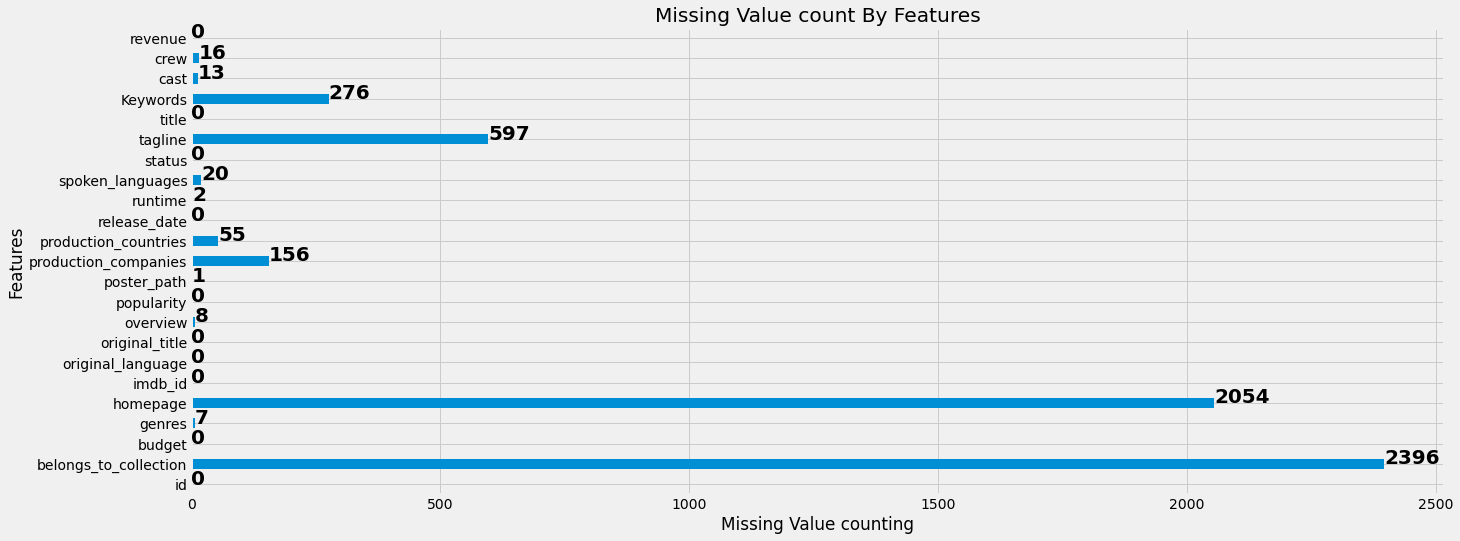

In [7]:
train.isna().sum().plot(kind="barh", figsize=(20,8))
for i, v in enumerate(train.isna().sum()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 20)
plt.xlabel("Missing Value counting")
plt.ylabel("Features")
plt.title("Missing Value count By Features")

In [8]:
#percentage 
pct_nans = round(train.isnull().sum()/shape[0]*100,1).to_frame().sort_values(by=[0], ascending=False)

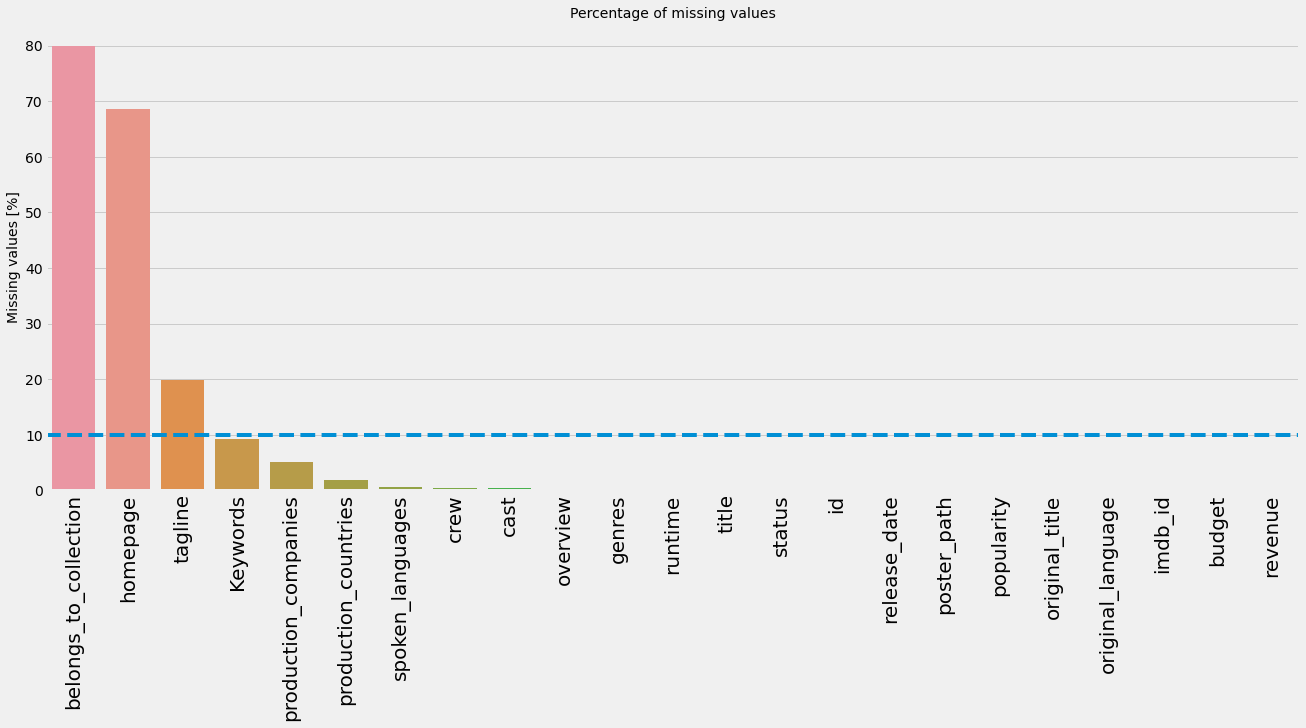

In [9]:
# creating a bar chart
plt.figure(figsize=(20,8))
sns.barplot(x=pct_nans.index, y=pct_nans[0])
plt.axhline(10, ls="--")
plt.xticks(rotation=90, fontsize=20)
plt.title("Percentage of missing values", fontsize=14)
plt.ylabel("Missing values [%]", fontsize=14)
plt.show()

In [10]:
train

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.326300
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",18.370959
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",16.387512
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16.588099
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",15.182615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,4/22/94,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was supposed to be a routine prisoner trans...,Chasers,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",14.283442
2996,2997,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,tt2364975,sv,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,3/28/13,102.0,"[{'iso_639_1': 'sv', 'name': 'svenska'}]",Released,NaN,We Are the Best!,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de...",12.103990
2997,2998,NaN,65000000,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,tt0116908,en,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,10/11/96,120.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What's forgotten is not always gone.,The Long Kiss Goodnight,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 10, 'character': 'Samantha Caine ...","[{'credit_id': '52fe443a9251416c7502d579', 'de...",18.309266
2998,2999,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...


Belongs_to_collection:
Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. Lets keep it simple and make it a yes(1)/no(0).

In [11]:
train.belongs_to_collection.describe()

count                                                   604
unique                                                  422
top       [{'id': 645, 'name': 'James Bond Collection', ...
freq                                                     16
Name: belongs_to_collection, dtype: object

Budget means the budget of the movie in dollars. 0 values means unknown. 
It is a lot of unknown values here and we should try to replace them

Homepage: This contains the official homepage URL of the movie.

Imdb_id, Keywords, Poster path, Original_title, Overview,Spoken languages, Status & Title: Theese are most likely containing useless links  or  has little significance meaning, so i Will drop them for now.f

In [12]:
train.status.value_counts()
#only 4 values are 'rumored'

Released    2996
Rumored        4
Name: status, dtype: int64

In [13]:
train.Keywords.value_counts()

[{'id': 10183, 'name': 'independent film'}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                           27
[{'id': 187056, 'name': 'woman director'}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Original_language is the language that the movie was made in. This is in a two digit code.

Popularity of the movie in float

Production_companies: All the production company name and the TMDB id in JSON format.

Production_countries: A two digit code and full name of the production company in JSON format.

In [14]:
train.production_countries.value_counts()

[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                                                                      1752
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                       118
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                                                                                  94
[{'iso_3166_1': 'IN', 'name': 'India'}]                                                                                                                                                           69
[{'iso_3166_1': 'FR', 'name': 'France'}]                                                                                                                                                          51
               

In [15]:
#Release_date:  
#The release date of the movie in th this format:  mm/dd/yy 
#Lets test that
test.release_date.head(30)

0      7/14/07
1      5/19/58
2      5/23/97
3       9/4/10
4      2/11/05
5       2/7/96
6     12/23/10
7      2/11/00
8       3/2/07
9     10/30/99
10      9/1/05
11     6/27/14
12     9/10/80
13     5/16/02
14      9/9/08
15     9/12/10
16     3/26/10
17     4/16/14
18    12/20/79
19    11/18/97
20     9/11/98
21     9/19/08
22      9/8/06
23     8/27/04
24     4/15/16
25    11/15/91
26      7/6/88
27    10/14/16
28     5/16/12
29     8/17/01
Name: release_date, dtype: object

Runtime: the total runtime of a movie in minutes.

Tagline of a movie

Cast: All cast TMDB id, name, character name, gender (1 = Female, 2 = Male). That is in JSON format

In [16]:
train.cast.describe()

count     2987
unique    2975
top         []
freq        13
Name: cast, dtype: object

In [17]:
#Crew: Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc
train.crew.value_counts()

[{'credit_id': '52fe438cc3a36847f805cba9', 'department': 'Art', 'gender': 2, 'id': 3188, 'job': 'Production Design', 'name': 'Victor Kempster', 'profile_path': None}, {'credit_id': '52fe438cc3a36847f805cba3', 'department': 'Production', 'gender': 1, 'id': 1484, 'job': 'Casting', 'name': 'Ellen Chenoweth', 'profile_path': None}, {'credit_id': '52fe438cc3a36847f805cb61', 'department': 'Directing', 'gender': 2, 'id': 8246, 'job': 'Director', 'name': 'Barry Levinson', 'profile_path': '/AvPOBBODhSCtUJAqxeq2s0nYnTw.jpg'}, {'credit_id': '52fe438cc3a36847f805cb85', 'department': 'Production', 'gender': 2, 'id': 8246, 'job': 'Producer', 'name': 'Barry Levinson', 'profile_path': '/AvPOBBODhSCtUJAqxeq2s0nYnTw.jpg'}, {'credit_id': '52fe438cc3a36847f805cb9d', 'department': 'Editing', 'gender': 2, 'id': 5166, 'job': 'Editor', 'name': 'Stu Linder', 'profile_path': None}, {'credit_id': '52fe438cc3a36847f805cb91', 'department': 'Sound', 'gender': 2, 'id': 19155, 'job': 'Original Music Composer', 'name'

Revenue: Total revenue earned by a movie in dollars. It is a label

In [18]:
# how the train data correlates to label revenue

corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue       1.000000
budget        0.485856
popularity    0.288506
runtime       0.210098
id            0.014447
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Budget')

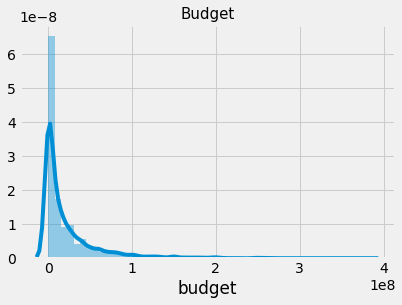

In [19]:
sns.distplot(train["budget"])
plt.title( "Budget", fontsize=15)

Text(0.5, 1.0, 'Revenue')

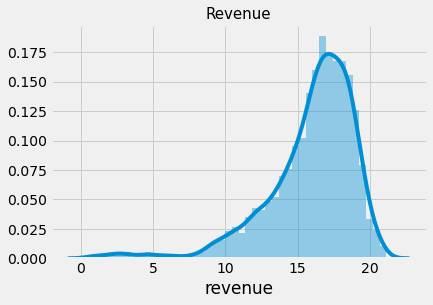

In [20]:
sns.distplot(train["revenue"])
plt.title( "Revenue", fontsize=15)

understand the popularity of the genres

In [21]:
X.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3000.000000
mean,1500.500000,2.253133e+07,8.463274,107.856571,15.961986
std,866.169729,3.702609e+07,12.104000,22.086434,3.061311
min,1.000000,0.000000e+00,0.000001,0.000000,0.693147
25%,750.750000,0.000000e+00,4.018053,94.000000,14.682517
50%,1500.500000,8.000000e+06,7.374861,104.000000,16.637310
75%,2250.250000,2.900000e+07,10.890983,118.000000,18.048445
max,3000.000000,3.800000e+08,294.337037,338.000000,21.141685


4.Preparing the data

Its tiime to fix things

And a lot of cleaning to do

First release_date

In [22]:
# Splitting release_date into some colums
def date_features(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df.drop(columns=['release_date'], inplace=True)
    return df

In [23]:
train = date_features(train)

In [24]:
train[["release_year", "release_month"]].describe()

,release_year,release_month
count,3000.000000,3000.000000
mean,2004.779667,6.775333
std,15.664767,3.409115
min,1970.000000,1.000000
25%,1995.000000,4.000000
50%,2006.000000,7.000000
75%,2012.000000,10.000000
max,2069.000000,12.000000


What about release_year = 2069?   we have to check it

In [25]:
train[train["release_year"] >=2017]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,release_year,release_month
39,40,NaN,3800000,"[{'id': 10752, 'name': 'War'}, {'id': 37, 'nam...",NaN,tt0059418,en,Major Dundee,"During the last winter of the Civil War, caval...",3.055936,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Major Dundee,"[{'id': 534, 'name': 'mexico'}, {'id': 1968, '...","[{'cast_id': 1, 'character': 'Major Amos Charl...","[{'credit_id': '52fe45f5c3a368484e078d7b', 'de...",9.607370,2065,4
41,42,NaN,3000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,tt0061512,en,Cool Hand Luke,When petty criminal Luke Jackson is sentenced ...,9.718713,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What we've got here is failure to communicate.,Cool Hand Luke,"[{'id': 378, 'name': 'prison'}, {'id': 526, 'n...","[{'cast_id': 13, 'character': 'Luke Jackson', ...","[{'credit_id': '52fe428ac3a36847f8026d8d', 'de...",16.601618,2067,6
48,49,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,tt1781058,en,Wilson,"Middle-aged and divorced, Wilson finds himself...",8.984386,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Wilson,"[{'id': 2487, 'name': 'naivety'}, {'id': 2794,...","[{'cast_id': 5, 'character': 'Wilson', 'credit...","[{'credit_id': '5590cb95c3a36807f6000075', 'de...",13.390789,2017,3
51,52,NaN,12000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,tt0059243,en,The Great Race,"Professional daredevil and white-suited hero, ...",4.473327,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"The movie with 20,000-mile or one-million-laug...",The Great Race,"[{'id': 9253, 'name': 'slapstick'}, {'id': 159...","[{'cast_id': 1, 'character': 'Prof. Fate', 'cr...","[{'credit_id': '52fe445e9251416c75032581', 'de...",17.047632,2065,7
61,62,NaN,4000000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0049875,en,Trapeze,"A pair of men try to perform the dangerous ""tr...",1.801071,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,High...High...High...Above Them All! - in exci...,Trapeze,"[{'id': 291, 'name': 'circus'}, {'id': 180181,...","[{'cast_id': 2, 'character': 'Mike Ribble', 'c...","[{'credit_id': '52fe4594c3a36847f80cf3b9', 'de...",16.482739,2056,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,2946,NaN,1000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,tt0057590,en,Tom Jones,Tom loves Sophie and Sophie loves Tom. But Tom...,3.315827,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Tom Jones! . . . loves and loves and loves and...,Tom Jones,"[{'id': 5626, 'name': 'from rags to riches'}, ...","[{'cast_id': 6, 'character': 'Tom Jones', 'cre...","[{'credit_id': '52fe4421c3a36847f8084025', 'de...",17.442515,2063,10
2946,2947,NaN,483103,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,tt0018183,en,My Best Girl,"Joe Merrill, son of the millionaire owner of a...",0.205671,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,My Best Girl,NaN,"[{'cast_id': 1, 'character': 'Maggie Johnson',...","[{'credit_id': '58f2c8ac9251413d6e007220', 'de...",13.842890,2027,10
2962,2963,NaN,20000000,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",http://www.theshack.movie,tt2872518,en,The Shack,"After suffering a family tragedy, Mack Phillip...",16.392712,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,You're never as alone as you think.,The Shack,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 0, 'character': 'Mack Phillips', ...","[{'credit_id': '591ed967c3a368799b03016c', 'de...",17.864350,2017,3
2967,2968,"[{'id': 387219, 'name': 'The Hustler Collectio...",2000000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0054997,en,The Hustler,Fast Eddie Felson is a small-time pool hustler...,9.333533,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They called him Fast Eddie. 


Note:  The "newest" movies are from 2017. 
And the movies from 2061 is actually from the past. An Example is The Hustler who is actually from 1961.

we can check in the test set

In [26]:
#test[["release_year", "release_month"]].describe()

In [27]:
#That is correct . all movies before to 1970 has been missspelled as 20 something. 
# We can correct this or just remove the incorrect values. 
 #The point is to predict future releases, so we choose the option to removing the old ones.

Get the Release of movies in Year,Day and finally week day

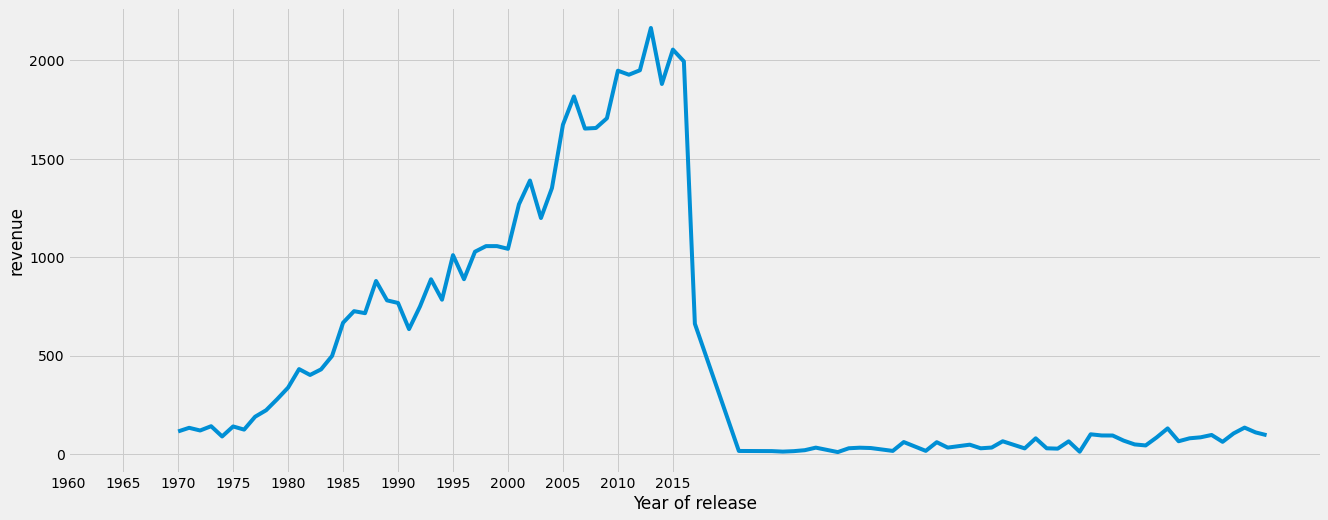

In [28]:
#Year distribution
data_plot = train[['revenue', 'release_year']]
money_Y = data_plot.groupby('release_year')['revenue'].sum()

money_Y.plot(figsize=(20,8))
plt.xlabel("Year of release")
plt.ylabel("revenue")
plt.xticks(np.arange(1960,2017,5))

plt.show()

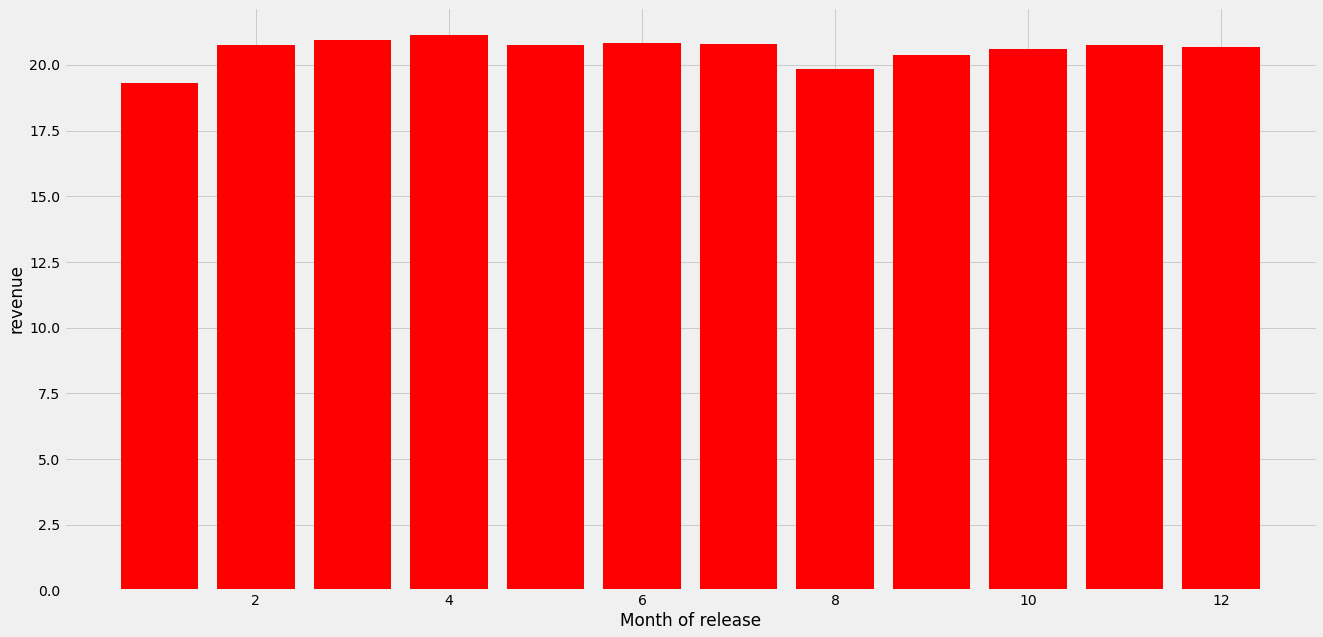

In [29]:
#month distribution
f,ax = plt.subplots(figsize=(20, 10))
plt.bar(train.release_month, train.revenue, color = 'red')
plt.xlabel("Month of release")
plt.ylabel("revenue")
plt.show()


MAybe we can take the day of week ?? Something like that

plt.figure(figsize=(20,10))
sns.countplot(train['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

Is the movie realesed???

In [30]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

4 movies is 'rumored'

In [31]:
train.loc[train['status'] == "Rumored"][['status','revenue']]

,status,revenue
609,Rumored,12.519587
1007,Rumored,4.110874
1216,Rumored,16.412115
1618,Rumored,12.341482


movie is yet to release and revenue is already given. Strange

In [32]:
test['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

in the test data is there 7 movies are yet to release and rest is released

Language

In [33]:
train.original_language

0       en
1       en
2       en
3       hi
4       ko
        ..
2995    en
2996    sv
2997    en
2998    en
2999    en
Name: original_language, Length: 3000, dtype: object

In [34]:
for col in ['original_language']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))
    train.original_language.describe()

genre

In [35]:
train.genres.shape

(3000,)

In [36]:
train.genres

0                          [{'id': 35, 'name': 'Comedy'}]
1       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
                              ...                        
2995    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2996    [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...
2997    [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...
2998    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2999    [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
Name: genres, Length: 3000, dtype: object

In [37]:
#preprocessing on the string values
train.genres = train.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.genres = test.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

train.genres.head(25)

0                                         [Comedy]
1                 [Comedy, Drama, Family, Romance]
2                                          [Drama]
3                                [Thriller, Drama]
4                               [Action, Thriller]
5                   [Animation, Adventure, Family]
6                               [Horror, Thriller]
7                                    [Documentary]
8       [Action, Comedy, Music, Family, Adventure]
9                                  [Comedy, Music]
10                                         [Drama]
11                                        [Comedy]
12                                         [Drama]
13                                 [Comedy, Crime]
14    [Action, Thriller, Science Fiction, Mystery]
15                          [Action, Crime, Drama]
16                              [Horror, Thriller]
17                                [Drama, Romance]
18                               [Comedy, Romance]
19                       [Actio

In [38]:
genres = Counter(itertools.chain.from_iterable(pd.concat((train.genres, test.genres), axis=0).values))
genres

Counter({'Comedy': 2605,
         'Drama': 3676,
         'Family': 675,
         'Romance': 1435,
         'Thriller': 1869,
         'Action': 1735,
         'Animation': 382,
         'Adventure': 1116,
         'Horror': 735,
         'Documentary': 221,
         'Music': 267,
         'Crime': 1084,
         'Science Fiction': 744,
         'Mystery': 550,
         'Foreign': 84,
         'Fantasy': 628,
         'War': 243,
         'Western': 117,
         'History': 295,
         'TV Movie': 1})

In [39]:
# Transforming from str(genres) to 1/0 with only the "best" four genres =1
train.best_genres = train.genres.apply(lambda y: list(map(lambda x: 1 if (x == "Action" or x == "Drama" or x == "Family" or x == "Comedy") else 0, y)))
train["best_genres"] = train.best_genres.apply(lambda x: 1 if (sum(x)>0) else 0)

In [40]:
train.best_genres.head(25)

0                 [1]
1        [1, 1, 1, 0]
2                 [1]
3              [0, 1]
4              [1, 0]
5           [0, 0, 1]
6              [0, 0]
7                 [0]
8     [1, 1, 0, 1, 0]
9              [1, 0]
10                [1]
11                [1]
12                [1]
13             [1, 0]
14       [1, 0, 0, 0]
15          [1, 0, 1]
16             [0, 0]
17             [1, 0]
18             [1, 0]
19          [1, 0, 0]
20          [0, 1, 0]
21             [0, 0]
22             [0, 0]
23          [0, 0, 0]
24             [0, 1]
Name: genres, dtype: object

In [41]:
train["best_genres"] = train.best_genres

In [42]:
train.describe()

,id,budget,original_language,popularity,runtime,revenue,release_year,release_month
count,3000.000000,3.000000e+03,3000.000000,3000.000000,2998.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,2.253133e+07,11.475000,8.463274,107.856571,15.961986,2004.779667,6.775333
std,866.169729,3.702609e+07,5.321981,12.104000,22.086434,3.061311,15.664767,3.409115
min,1.000000,0.000000e+00,1.000000,0.000001,0.000000,0.693147,1970.000000,1.000000
25%,750.750000,0.000000e+00,10.000000,4.018053,94.000000,14.682517,1995.000000,4.000000
50%,1500.500000,8.000000e+06,10.000000,7.374861,104.000000,16.637310,2006.000000,7.000000
75%,2250.250000,2.900000e+07,10.000000,10.890983,118.000000,18.048445,2012.000000,10.000000
max,3000.000000,3.800000e+08,43.000000,294.337037,338.000000,21.141685,2069.000000,12.000000


In [43]:
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue              1.000000
budget               0.485856
popularity           0.288506
runtime              0.210098
release_month        0.031051
id                   0.014447
release_year        -0.071098
original_language   -0.139569
Name: revenue, dtype: float64

In [44]:
my_genres = [g for g in genres if g != 'TV Movie']
my_genres

['Comedy',
 'Drama',
 'Family',
 'Romance',
 'Thriller',
 'Action',
 'Animation',
 'Adventure',
 'Horror',
 'Documentary',
 'Music',
 'Crime',
 'Science Fiction',
 'Mystery',
 'Foreign',
 'Fantasy',
 'War',
 'Western',
 'History']

Production companies

In [46]:
# Transforming from JSON to Dictionary columns:
dict_columns = ['production_companies','cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [47]:
train = text_to_dict(train)
test = text_to_dict(test)

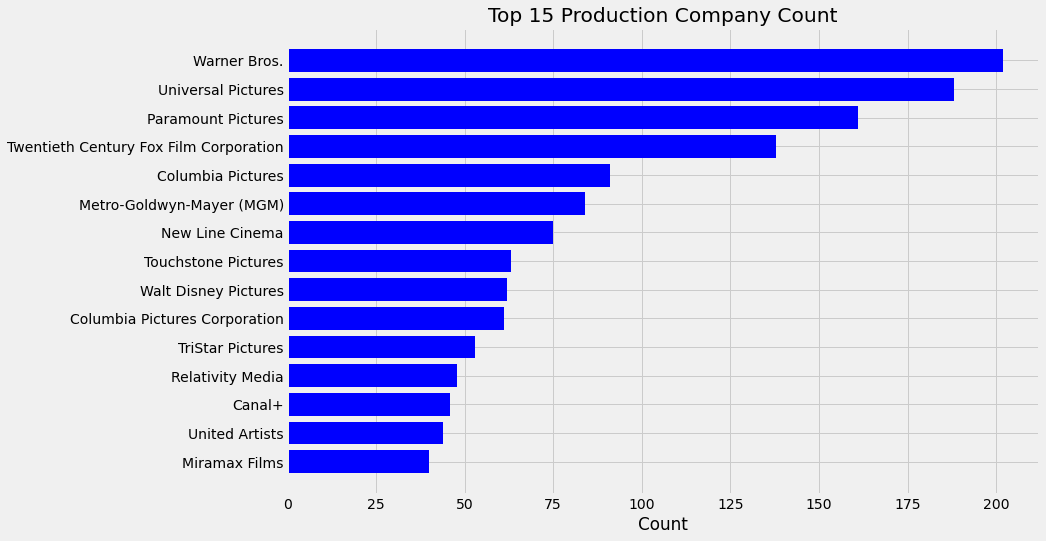

In [48]:
# Counting the frequency of production company 

list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_companies=Counter([i for j in list_of_companies for i in j]).most_common(15)

fig = plt.figure(figsize=(12, 8))
data=dict(most_common_companies)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names, color='blue')
plt.xlabel('Count')
plt.title('Top 15 Production Company Count')
plt.show()

In [49]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 55 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   id                                                         3000 non-null   int64  
 1   belongs_to_collection                                      604 non-null    object 
 2   budget                                                     3000 non-null   int64  
 3   genres                                                     3000 non-null   object 
 4   homepage                                                   946 non-null    object 
 5   imdb_id                                                    3000 non-null   object 
 6   original_language                                          3000 non-null   int32  
 7   original_title                                             3000 non-null   object 
 8   overview

Cast

In [50]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(30)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21),
 ('Frank Welker', 20),
 ('Michael Caine', 20),
 ('George Clooney', 20),
 ('Denzel Washington', 20),
 ('Robert Duvall', 20),
 ('Ed Harris', 20),
 ('Dennis Quaid', 20),
 ('Richard Jenkins', 20),
 ('Matt Damon', 20),
 ('Christopher Plummer', 19)]

In [51]:
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(29)]

In [52]:
top_cast_names

['Samuel L. Jackson',
 'Robert De Niro',
 'Morgan Freeman',
 'J.K. Simmons',
 'Bruce Willis',
 'Liam Neeson',
 'Susan Sarandon',
 'Bruce McGill',
 'John Turturro',
 'Forest Whitaker',
 'Willem Dafoe',
 'Bill Murray',
 'Owen Wilson',
 'Nicolas Cage',
 'Sylvester Stallone',
 'Jason Statham',
 'Keith David',
 'John Goodman',
 'Mel Gibson',
 'Sigourney Weaver',
 'Frank Welker',
 'Michael Caine',
 'George Clooney',
 'Denzel Washington',
 'Robert Duvall',
 'Ed Harris',
 'Dennis Quaid',
 'Richard Jenkins',
 'Matt Damon']

In [54]:
train.best_genres = train.genres.apply(lambda y: list(map(lambda x: 1 if (x == "Action" or x == "Drama" or x == "Family" or x == "Comedy") else 0, y)))
train["best_genres"] = train.best_genres.apply(lambda x: 1 if (sum(x)>0) else 0)

In [55]:
train["includes_famous_actor"] = train["cast"].apply(lambda x: list(map(lambda y: 1 if (y in top_cast_names) else 0, x)))
#[s for s in train["cast"] if any(xs in s for xs in top_cast_names)]

In [56]:
train["includes_famous_actor"] = train["includes_famous_actor"].apply(lambda x: 1 if (sum(x)>0) else 0)

In [57]:
train["includes_famous_actor"].head(49)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
Name: includes_famous_actor, dtype: int64

In [58]:
train["includes_famous_actor"]

0       0
1       0
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: includes_famous_actor, Length: 3000, dtype: int64

In [61]:
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(20)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)

In [62]:
train

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,[Comedy],NaN,tt2637294,10,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,10,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,0,0,0,0,0,0
2,3,NaN,3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,10,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,0,0
3,4,NaN,1200000,"[Thriller, Drama]",http://kahaanithefilm.com/,tt1821480,16,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,0,0,0,0,0
4,5,NaN,0,"[Action, Thriller]",NaN,tt1380152,24,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[Comedy, Romance]",NaN,tt0109403,10,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,0,0,0,0,0,0,0,0,0,0
2996,2997,NaN,0,"[Drama, Music]",NaN,tt2364975,35,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,0,0,0,0,0,0,0,0,0,0
2997,2998,NaN,65000000,"[Crime, Action, Mystery, Thriller]",NaN,tt0116908,10,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,0,0,0,0,0,0,0,0,0,0
2998,2999,NaN,42000000,"[Comedy, Romance]",http://www.alongcamepolly.com/,tt0343135,10,Along Came Polly,Reuben Feffer is a guy who's spent his entire ...,15.725542,...,0,0,0,0,0,0,0,0,0,0


Crew

In [63]:
directors = train['crew'].apply(lambda x: [i["name"] for i in x if i['job'] == "Director"])
Counter([i for j in directors for i in j]).most_common(20)

[('Ron Howard', 11),
 ('Clint Eastwood', 11),
 ('Steven Spielberg', 10),
 ('Blake Edwards', 9),
 ('Woody Allen', 9),
 ('Wes Craven', 8),
 ('Martin Scorsese', 8),
 ('Paul W.S. Anderson', 8),
 ('Alfred Hitchcock', 8),
 ('Michael Bay', 8),
 ('Francis Ford Coppola', 8),
 ('Brian De Palma', 8),
 ('Steven Soderbergh', 8),
 ('Joel Schumacher', 7),
 ('Peter Hyams', 7),
 ('Peter Jackson', 7),
 ('Michael Mann', 7),
 ('Robert Rodriguez', 7),
 ('Tim Burton', 7),
 ('Billy Wilder', 7)]

In [64]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_directors = [m[0] for m in Counter([i for j in directors for i in j]).most_common(20)]
for g in top_directors:
    train['director_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_directors:
    test['director_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)

In [65]:
train['num_crew']

0       72
1        9
2       64
3        3
4        2
        ..
2995    17
2996    15
2997    10
2998    89
2999    48
Name: num_crew, Length: 3000, dtype: int64

The rest 

In [66]:
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=True)

original_language              -0.139569
release_year                   -0.071098
production_company_BBC Films   -0.016566
director_Billy Wilder          -0.014540
production_company_Canal+      -0.008120
                                  ...   
popularity                      0.288506
num_crew                        0.341304
budget                          0.485856
revenue                         1.000000
includes_famous_actor                NaN
Name: revenue, Length: 82, dtype: float64

In [67]:
class FeatureAdder(BaseEstimator,TransformerMixin):
    
    def fit(self,df,y=None):
     return self
    
    def transform(self,df, y=None):
      df["tagline"] = df.tagline.isnull() # Only keeping if the movie has a tagline or not
      df["tagline"] = df.tagline.astype("int32")
      df["homepage"] = df.homepage.isnull() # Don't care about the address but lets check if movies with a homepage has a higher revenue(or lower).
      df["homepage"] = df.homepage.astype("int32")
      df["belongs_to_collection"] = df.belongs_to_collection.isnull()
      df["belongs_to_collection"] = df.belongs_to_collection.astype("int32")
      df["title_length"] = df.title.str.len()
      df.drop(columns=["imdb_id"], inplace=True)
      df.drop(columns=["poster_path"], inplace=True)
      df.drop(columns=["status"], inplace=True)
      df.drop(columns=["overview"], inplace=True)
      df.drop(columns=["original_title"], inplace=True)
      df.drop(columns=["spoken_languages"], inplace=True)
      df.drop(columns=["Keywords"], inplace=True)
      df.drop(columns=["production_countries"], inplace=True)
      df.drop(columns=["title"], inplace=True)
      df.drop(columns=['crew'], inplace=True)
      df.drop(columns=['genres'], inplace=True)
      df.drop(columns=['cast'], inplace=True)
        
      return df

In [68]:
test

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,director_Francis Ford Coppola,director_Brian De Palma,director_Steven Soderbergh,director_Joel Schumacher,director_Peter Hyams,director_Peter Jackson,director_Michael Mann,director_Robert Rodriguez,director_Tim Burton,director_Billy Wilder
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[Adventure, Animation, Family, Fantasy]",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,21,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3002,NaN,88000,"[Horror, Science Fiction]",NaN,tt0051380,10,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3003,NaN,0,"[Comedy, Romance]",NaN,tt0118556,10,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3004,NaN,6800000,"[Drama, War, Mystery]",http://www.sonyclassics.com/incendies/,tt1255953,14,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3005,NaN,2000000,"[History, Documentary]",NaN,tt0418753,10,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,7394,NaN,42000000,[Thriller],NaN,tt0218922,10,Original Sin,A young man is plunged into a life of subterfu...,9.970359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4394,7395,"[{'id': 146534, 'name': 'Without a Paddle Coll...",19000000,"[Action, Adventure, Comedy, Thriller]",NaN,tt0364751,10,Without a Paddle,"Three friends, whose lives have been drifting ...",6.046516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4395,7396,NaN,16000000,[Drama],NaN,tt0084855,10,The Verdict,"Frank Galvin is a down-on-his luck lawyer, red...",9.596883,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4396,7397,NaN,2000000,"[Horror, Thriller]",NaN,tt3235888,10,It Follows,"For 19-year-old Jay, fall should be about scho...",20.359336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
test = test.drop("id", axis=1)


In [70]:
train = FeatureAdder().fit_transform(train)
test = FeatureAdder().transform(test)

In [71]:
# checking how the train data correlates to label(revenue)

corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue                  1.000000
budget                   0.485856
num_crew                 0.341304
popularity               0.288506
runtime                  0.210098
                           ...   
original_language       -0.139569
homepage                -0.143133
belongs_to_collection   -0.256553
tagline                 -0.319559
includes_famous_actor         NaN
Name: revenue, Length: 86, dtype: float64

In [72]:
# removing Label(revenue) and id before scaling

train_backup = train 
labels = train["revenue"].copy() 
X=train.drop(['id', 'revenue'], axis=1)


y = np.log1p(train['revenue'])

In [73]:
# pipeline for scaling and imputing

pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median")),
])

prepared = pipeline.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [74]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[585]	training's rmse: 0.162497	valid_1's rmse: 0.21119


Weight,Feature
0.4649,budget
0.1808,popularity
0.1041,runtime
0.0920,release_year
0.0375,num_crew
0.0365,release_month
0.0311,title_length
0.0118,original_language
0.0117,num_companies
0.0110,belongs_to_collection


In [75]:
# Print the best parameters found
gridParams = {
    "max_depth": [4],
    "min_data_in_leaf": [15],
    'learning_rate': [0.01],
    'num_leaves': [40],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [501], 
    'reg_alpha' : [1],
    'reg_lambda' : [1.4, 1.5]
    }


grid_search = GridSearchCV(lgb_model, n_jobs=-1, param_grid=gridParams, cv = 3, verbose=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


Random_Search_Params ={
    "max_depth": [4],
    "min_data_in_leaf": [15],
    'learning_rate': [0.01],
    'num_leaves': [40],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [501], 
    }

n_HP_points_to_test = 50

random_search = RandomizedSearchCV(
    estimator=lgb_model, param_distributions= Random_Search_Params, 
    n_iter=n_HP_points_to_test,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

random_search.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

# Using parameters already set above, replace in the best from the random search

params['learning_rate'] = random_search.best_params_['learning_rate']
params['max_depth'] = random_search.best_params_['max_depth']
params['num_leaves'] = random_search.best_params_['num_leaves']

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   12.9s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.2s finished


{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 4, 'min_data_in_leaf': 15, 'num_leaves': 40, 'objective': 'regression', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1.5}
0.29210208583022695
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.3s finished


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Best score reached: 0.2899150333126286 with params: {'random_state': 501, 'objective': 'regression', 'num_leaves': 40, 'min_data_in_leaf': 15, 'max_depth': 4, 'learning_rate': 0.01, 'boosting_type': 'gbdt'

In [77]:
test.describe()

,belongs_to_collection,budget,homepage,original_language,popularity,runtime,tagline,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,...,director_Brian De Palma,director_Steven Soderbergh,director_Joel Schumacher,director_Peter Hyams,director_Peter Jackson,director_Michael Mann,director_Robert Rodriguez,director_Tim Burton,director_Billy Wilder,title_length
count,4398.000000,4.398000e+03,4398.000000,4398.000000,4398.000000,4394.000000,4398.000000,4398.000000,4398.000000,4398.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,4395.000000
mean,0.800591,2.264929e+07,0.677126,11.454297,8.550230,107.622212,0.196226,2.776035,0.068668,0.063211,...,0.002667,0.005000,0.002667,0.003000,0.003000,0.003333,0.003000,0.003333,0.002667,15.127873
std,0.399601,3.689991e+07,0.467628,5.272996,12.209014,21.058290,0.397186,2.296847,0.252917,0.243369,...,0.051579,0.070545,0.051579,0.054699,0.054699,0.057648,0.054699,0.057648,0.051579,8.390288
min,0.000000,0.000000e+00,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000e+00,0.000000,10.000000,3.895186,94.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
50%,1.000000,7.450000e+06,1.000000,10.000000,7.482241,104.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000
75%,1.000000,2.800000e+07,1.000000,10.000000,10.938524,118.000000,0.000000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
max,1.000000,2.600000e+08,1.000000,43.000000,547.488298,320.000000,1.000000,26.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,104.000000


In [79]:
len(test)

4398

Random Forrest

In [80]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# print_score function depending on the evaluation metric: rmse
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [82]:
#rf with hyper parameters
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [83]:
fi = rf_feat_importance(m, df_trn)
fi

NameError: name 'rf_feat_importance' is not defined

In [84]:
final_model = grid_search.best_estimator_
test_prepared = pipeline.fit(test)
final_predict = final_model.predict(test)
len(final_predict)

ValueError: could not convert string to float: '7/14/07'

In [47]:
# sample_submission['revenue'] = np.expm1(final_prediction + y_pred)/2
sample_submission['revenue'] = np.expm1(final_predict)
sample_submission.to_csv('submission2.csv', index=False)

In [49]:
from joblib import dump
dump(final_model, '../models/boxoffice_model.joblib', compress=6)

['../models/boxoffice_model.joblib']

In [ ]:
# We need the entire pipeline into the model. 
#Maybe like this? https://www.kaggle.com/evanmiller/pipelines-gridsearch-awesome-ml-pipelines